In [1]:
import sys
sys.path.append('./helpers')
sys.path.append('./optimizers')

In [2]:
# External libraries
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import networkx as nx
from deap import gp

# Custom functions and classes
from pymoo_optimizer import PymooOptimizer
import benchmark as Benchmark
import data_provider as dp
import feature_evolver as fe

In [3]:
x_train, x_test, x_val, y_train, y_test, y_val = dp.get_train_test_validation_data('breast', 0.8, 0.1)

In [4]:
heuristics_repeats = 1

optimizer = PymooOptimizer(x_train, x_val, y_train, y_val)
solution, score = optimizer.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

In [5]:
raw_score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)
optimized_score = np.round(Benchmark.dtree_accuracy(x_train.loc[:, solution], x_test.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)

print(f'After optimization, decision tree accuracy changed from {raw_score}% to {optimized_score}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train.columns[solution].tolist())}')

After optimization, decision tree accuracy changed from 92.11% to 93.86%

Optimal contains 53.3% less columns than the original dataset,reducing from 30 to 14

Selected columns are: radius1, area1, smoothness1, compactness1, concave_points1, symmetry1, fractal_dimension1, texture2, perimeter2, concavity2, area3, smoothness3, concave_points3, symmetry3


In [6]:
# Evolve a new feature
x_train_2, x_val_2, x_test_2 = fe.evolve_new_feature(optimizer, x_test, verbose=False, repeats=heuristics_repeats, name='new_feature')

# Check new feature
score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_test, heuristics_repeats) * 100, 2)

# Check feature selection
optimizer_2 = PymooOptimizer(x_train_2, x_val_2, y_train, y_val)
solution, score = optimizer_2.optimize(64, 100, Benchmark.dtree_accuracy, verbose = False, repeats=heuristics_repeats)

optimized_score_with_new_feature = np.round(Benchmark.dtree_accuracy(x_train_2.loc[:, solution], x_test_2.loc[:, solution], y_train, y_test, heuristics_repeats) * 100, 2)


print(f'After feature creation, decision tree accuracy changed to {score_with_new_feature}%\n\n' +
      f'After feature creation and selection, decision tree accuracy changed to {optimized_score_with_new_feature}%\n\n' +
        f'Optimal contains {np.round((x_train.shape[1] - np.sum(solution)) / x_train.shape[1] * 100, 1)}% less columns than the original dataset,' +
        f'reducing from {x_train_2.shape[1]} to {np.sum(solution)}\n\nSelected columns are: {", ".join(x_train_2.columns[solution].tolist())}')

After feature creation, decision tree accuracy changed to 92.11%

After feature creation and selection, decision tree accuracy changed to 93.86%

Optimal contains 53.3% less columns than the original dataset,reducing from 31 to 14

Selected columns are: area1, concavity1, concave_points1, fractal_dimension1, texture2, smoothness2, compactness2, concavity2, area3, smoothness3, compactness3, concave_points3, fractal_dimension3, new_feature


Feature as math expression: add(area2, mul(compactness3, perimeter1)) 



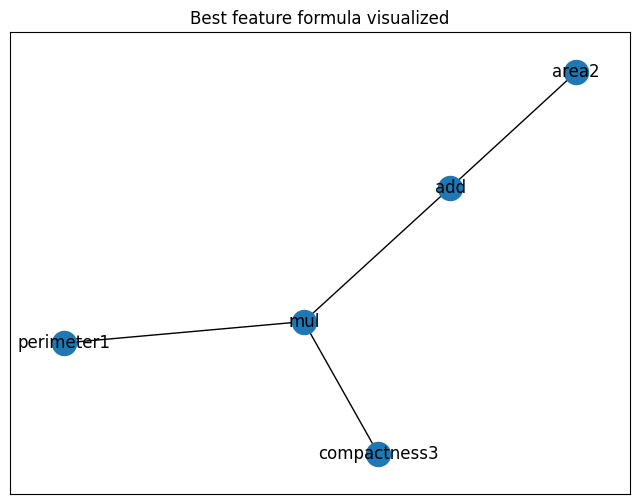

In [7]:
best_feature_func, best_individual = optimizer.evolve_new_feature(epochs=50, heuristics=Benchmark.dtree_accuracy, verbose=False)
print("Feature as math expression:", best_individual, "\n")

nodes, edges, labels = gp.graph(best_individual)
g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.spring_layout(g)

plt.figure(figsize=(8, 6))
plt.title("Best feature formula visualized")
nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

In [ ]:
optimizer_constructor = lambda x_train, x_val, y_train, y_val: PymooOptimizer(x_train, x_val, y_train, y_val)
x_train_2, x_test_2, x_val_2 = fe.evolve_new_feature_set(optimizer_constructor, x_train, x_val, y_train, y_val, x_test, verbose=False,
                                                        heuristics=Benchmark.dtree_accuracy, epochs=50, repeats=heuristics_repeats,
                                                        min_features=3, max_features=10)

score = np.round(Benchmark.dtree_accuracy(x_train, x_test, y_train, y_test, heuristics_repeats) * 100, 2)
new_score= np.round(Benchmark.dtree_accuracy(x_train_2, x_test_2, y_train, y_val, heuristics_repeats) * 100, 2)

print(f'After feature creation, decision tree accuracy was equal to {new_score}%\n\n' +
        f'With previous data, it was {score}%\n\n' +
        f'Optimal contains {100 - np.round(x_train_2.shape[1] / x_train.shape[1] * 100, 1)}% less columns than the original dataset')

After feature creation, decision tree accuracy was equal to 96.99%

With previous data, it was 92.98%

Optimal contains 90.0% less columns than the original dataset, list of columns: evolved_feature_1, evolved_feature_2, evolved_feature_3
